In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/AA II/NUEVO (1)


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [3]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)  # Salida para 7 clases
        self.fc4 = nn.Linear(128, 64)  # Salida para 7 clases
        self.fc5 = nn.Linear(64, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc_bn3 = nn.BatchNorm1d(128)
        self.fc_bn4 = nn.BatchNorm1d(64)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn3(self.fc3(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn4(self.fc4(x)))
        x = self.dropout_fc(x)

        x = self.fc5(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [5]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [6]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [7]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.7464, exactitud entrenamiento: 34.81%, exactitud validación: 34.13%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.4814, exactitud entrenamiento: 50.31%, exactitud validación: 49.17%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.3611, exactitud entrenamiento: 57.30%, exactitud validación: 54.95%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.2317, exactitud entrenamiento: 52.40%, exactitud validación: 52.66%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.1711, exactitud entrenamiento: 60.72%, exactitud validación: 58.07%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.0367, exactitud entrenamiento: 68.67%, exactitud validación: 64.68%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.9790, exactitud entrenamiento: 77.66%, exactitud validación: 71.93%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.8870, exactitud entrenamiento: 67.65%, exactitud validación: 63.

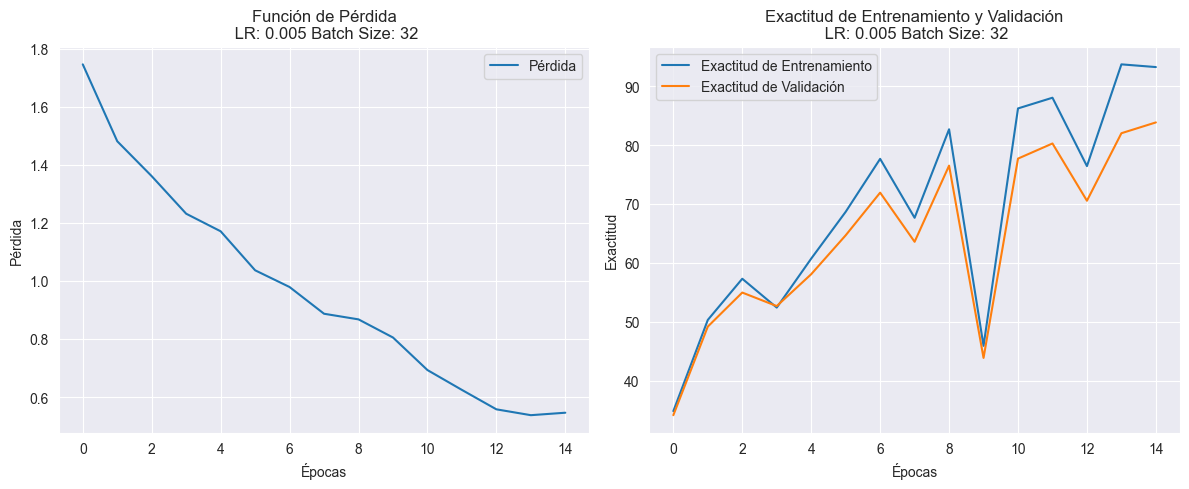


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.7232, exactitud entrenamiento: 15.62%, exactitud validación: 15.14%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5018, exactitud entrenamiento: 45.04%, exactitud validación: 45.60%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.3636, exactitud entrenamiento: 35.34%, exactitud validación: 36.79%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.2926, exactitud entrenamiento: 60.87%, exactitud validación: 58.53%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.1709, exactitud entrenamiento: 68.92%, exactitud validación: 64.40%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.1189, exactitud entrenamiento: 48.52%, exactitud validación: 47.06%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.0107, exactitud entrenamiento: 71.47%, exactitud validación: 69.17%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.9495, exactitud entrenamiento: 79.21%, exactitud validación: 74.

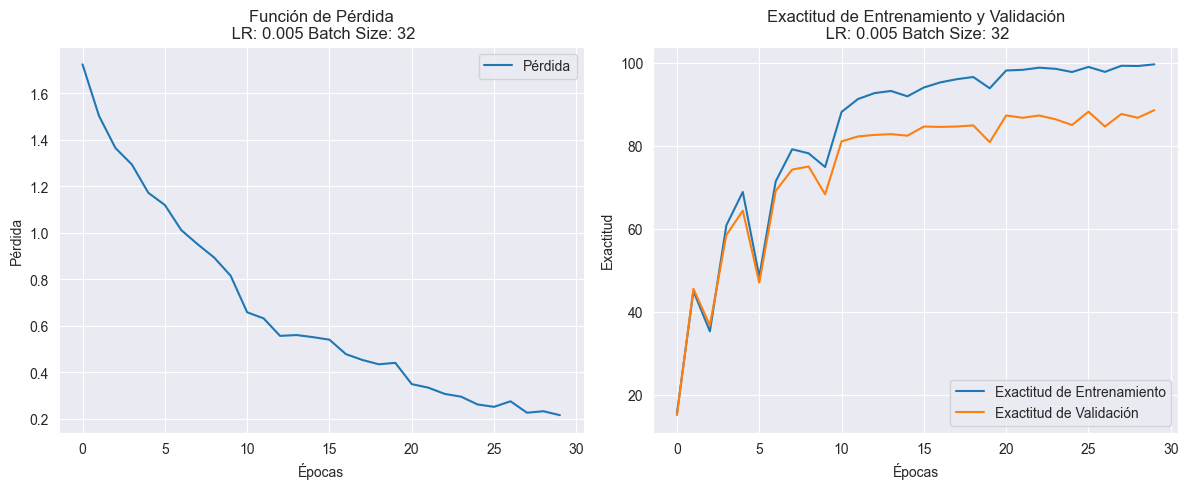


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.8060, exactitud entrenamiento: 26.22%, exactitud validación: 26.51%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5147, exactitud entrenamiento: 46.73%, exactitud validación: 45.41%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.3509, exactitud entrenamiento: 56.25%, exactitud validación: 54.68%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.2221, exactitud entrenamiento: 65.43%, exactitud validación: 62.20%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.0930, exactitud entrenamiento: 49.45%, exactitud validación: 48.72%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.9739, exactitud entrenamiento: 67.65%, exactitud validación: 65.78%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.9047, exactitud entrenamiento: 68.92%, exactitud validación: 65.87%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.8095, exactitud entrenamiento: 70.43%, exactitud validación: 67.

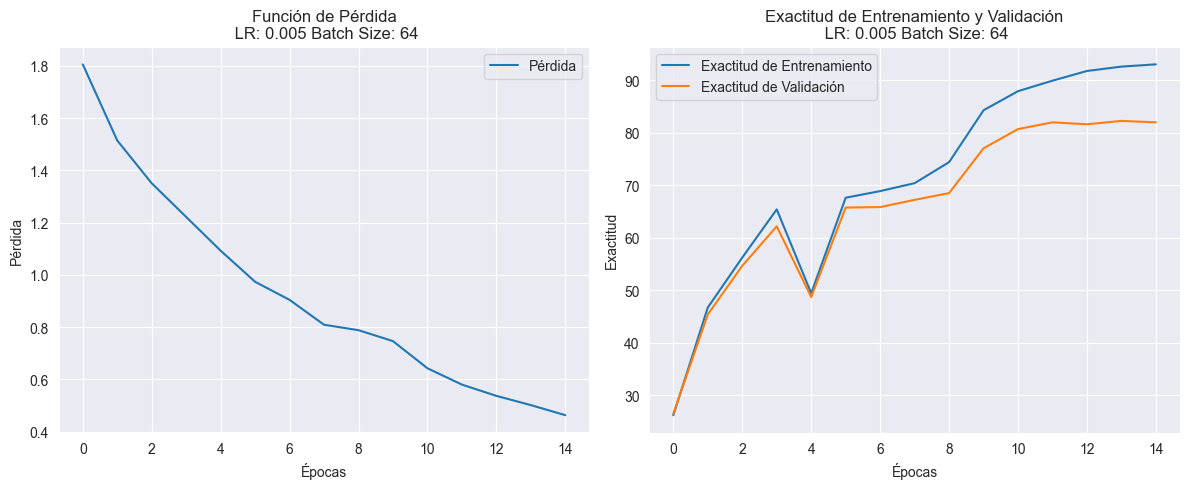


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.7657, exactitud entrenamiento: 38.94%, exactitud validación: 38.35%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.4908, exactitud entrenamiento: 51.23%, exactitud validación: 50.64%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.3550, exactitud entrenamiento: 35.03%, exactitud validación: 32.48%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.2258, exactitud entrenamiento: 50.59%, exactitud validación: 50.18%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.1174, exactitud entrenamiento: 62.17%, exactitud validación: 57.71%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.9956, exactitud entrenamiento: 27.39%, exactitud validación: 26.42%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.9208, exactitud entrenamiento: 78.00%, exactitud validación: 73.76%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.8624, exactitud entrenamiento: 75.54%, exactitud validación: 69.

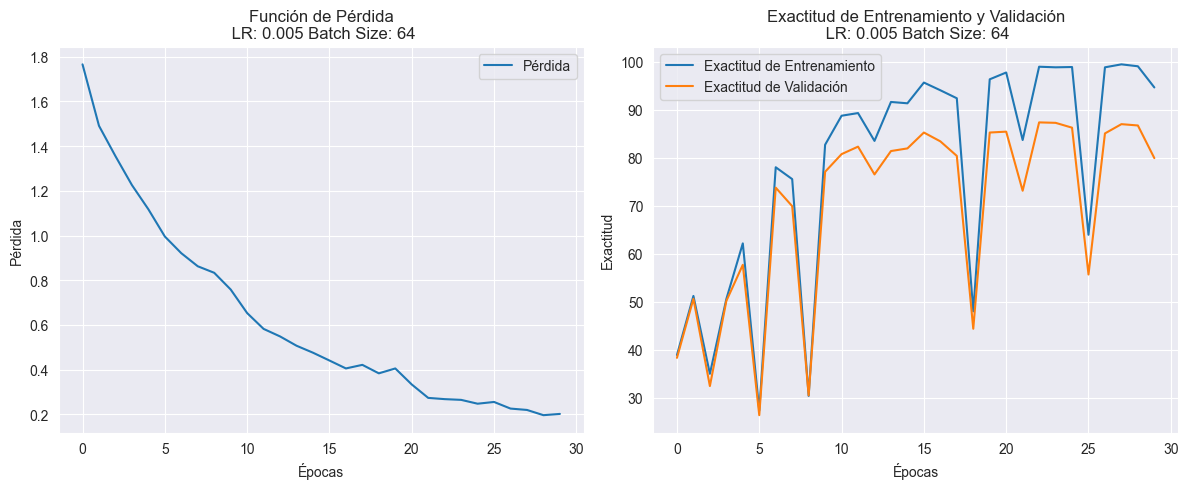


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.8241, exactitud entrenamiento: 14.63%, exactitud validación: 14.40%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.5220, exactitud entrenamiento: 49.14%, exactitud validación: 49.08%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.3315, exactitud entrenamiento: 53.70%, exactitud validación: 50.92%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.2023, exactitud entrenamiento: 36.48%, exactitud validación: 34.50%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.1184, exactitud entrenamiento: 70.55%, exactitud validación: 64.95%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.9706, exactitud entrenamiento: 49.45%, exactitud validación: 46.15%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.9408, exactitud entrenamiento: 64.70%, exactitud validación: 61.93%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.8671, exactitud entrenamiento: 79.67%, exactitud validación: 75.

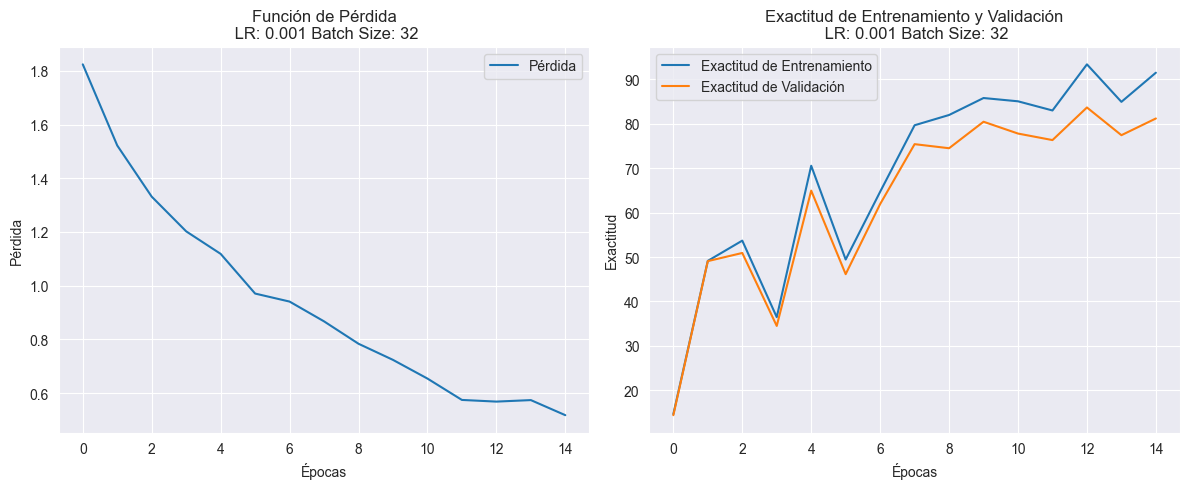


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.8111, exactitud entrenamiento: 24.00%, exactitud validación: 24.40%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.5176, exactitud entrenamiento: 33.46%, exactitud validación: 32.48%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.3555, exactitud entrenamiento: 37.92%, exactitud validación: 37.52%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.2435, exactitud entrenamiento: 51.60%, exactitud validación: 49.72%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.0971, exactitud entrenamiento: 71.57%, exactitud validación: 66.88%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.0148, exactitud entrenamiento: 71.66%, exactitud validación: 66.88%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.9425, exactitud entrenamiento: 24.12%, exactitud validación: 24.04%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.9054, exactitud entrenamiento: 73.84%, exactitud validación: 68.

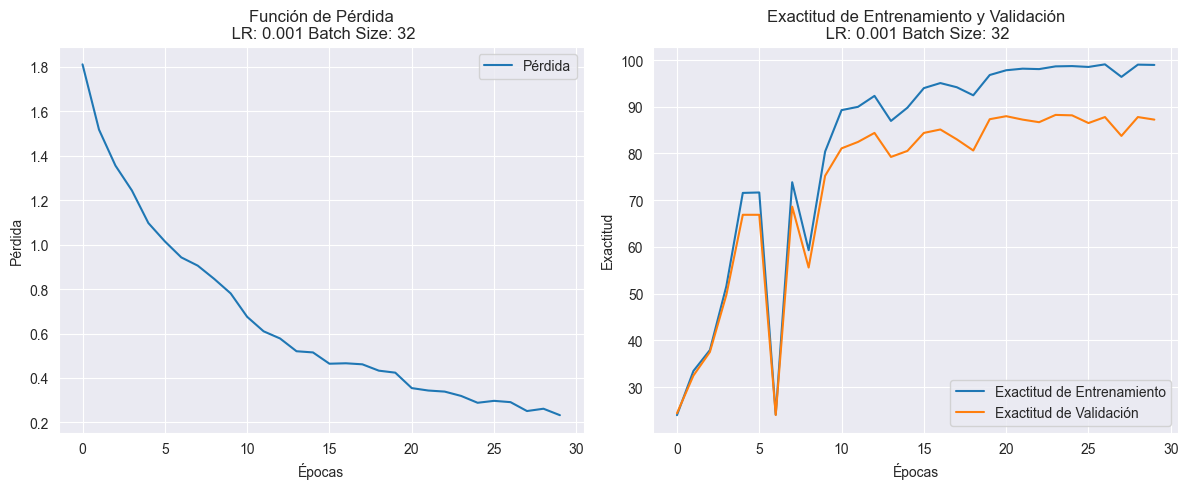


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.8560, exactitud entrenamiento: 14.79%, exactitud validación: 14.50%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.5732, exactitud entrenamiento: 26.59%, exactitud validación: 27.61%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.4051, exactitud entrenamiento: 58.41%, exactitud validación: 56.79%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.2088, exactitud entrenamiento: 62.20%, exactitud validación: 60.28%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.0880, exactitud entrenamiento: 69.16%, exactitud validación: 66.70%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.9340, exactitud entrenamiento: 67.38%, exactitud validación: 63.39%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.8831, exactitud entrenamiento: 77.14%, exactitud validación: 69.54%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.7858, exactitud entrenamiento: 60.51%, exactitud validación: 56.

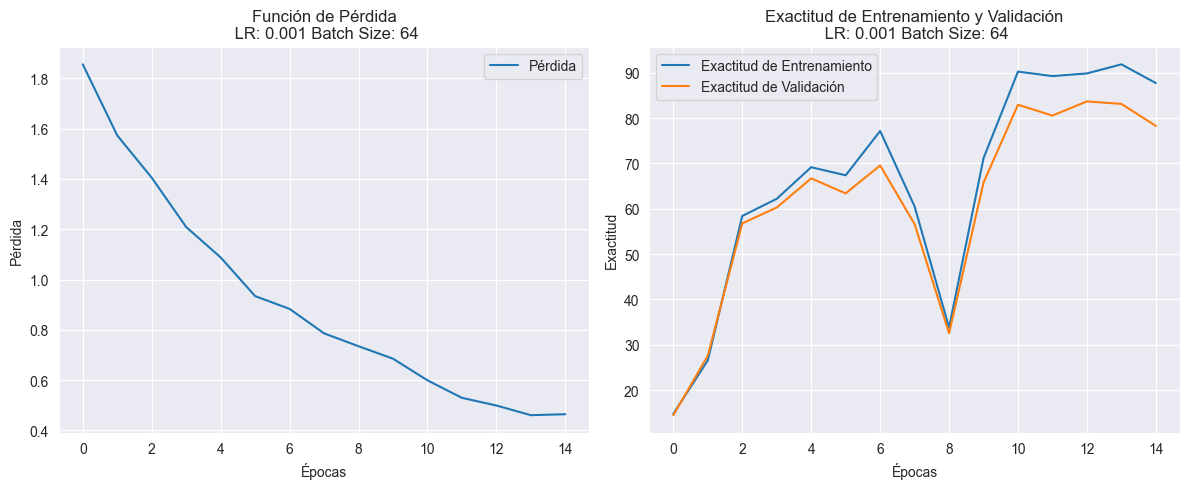


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.9270, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.6511, exactitud entrenamiento: 24.71%, exactitud validación: 24.22%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.4561, exactitud entrenamiento: 50.89%, exactitud validación: 47.25%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.3124, exactitud entrenamiento: 33.21%, exactitud validación: 32.29%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.1609, exactitud entrenamiento: 53.94%, exactitud validación: 52.02%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.0734, exactitud entrenamiento: 64.57%, exactitud validación: 62.48%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.9637, exactitud entrenamiento: 73.44%, exactitud validación: 71.01%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.8427, exactitud entrenamiento: 79.17%, exactitud validación: 76.

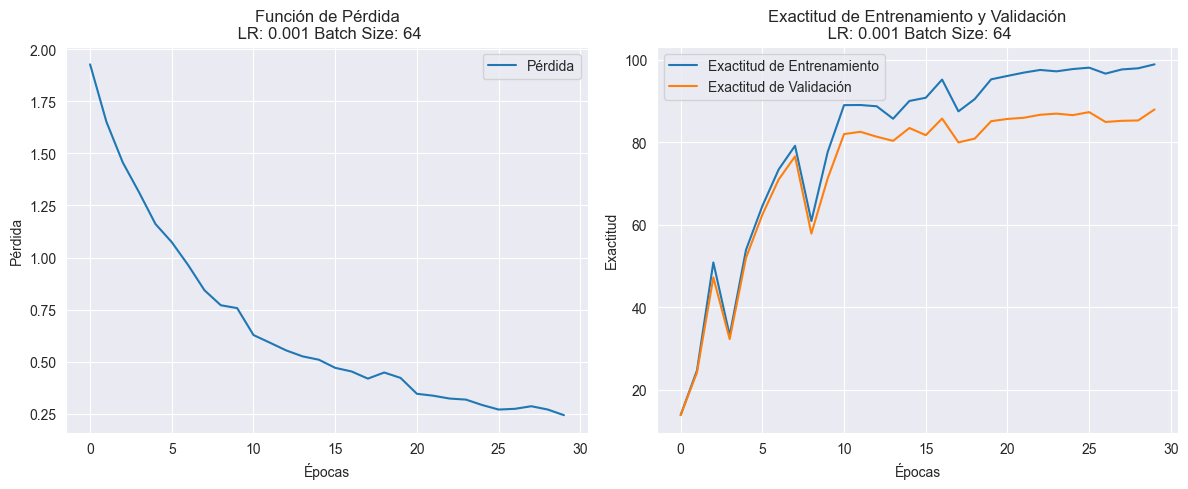


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.9269, exactitud entrenamiento: 14.05%, exactitud validación: 13.94%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.6772, exactitud entrenamiento: 25.94%, exactitud validación: 25.50%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.5066, exactitud entrenamiento: 38.17%, exactitud validación: 37.34%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.3724, exactitud entrenamiento: 41.53%, exactitud validación: 38.07%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.2619, exactitud entrenamiento: 40.85%, exactitud validación: 40.55%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.1390, exactitud entrenamiento: 48.40%, exactitud validación: 45.78%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.0412, exactitud entrenamiento: 65.83%, exactitud validación: 63.39%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.9926, exactitud entrenamiento: 71.97%, exactitud validación: 67

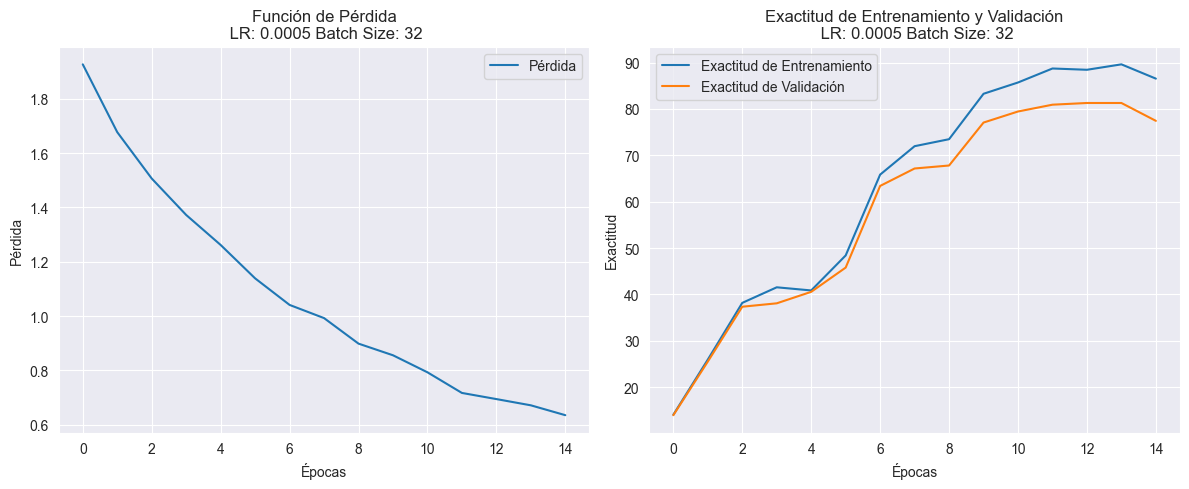


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.8955, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.6810, exactitud entrenamiento: 17.81%, exactitud validación: 18.99%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.4930, exactitud entrenamiento: 30.25%, exactitud validación: 28.99%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.3642, exactitud entrenamiento: 34.23%, exactitud validación: 34.31%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.2391, exactitud entrenamiento: 48.15%, exactitud validación: 47.43%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.1570, exactitud entrenamiento: 63.34%, exactitud validación: 63.39%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.0394, exactitud entrenamiento: 69.47%, exactitud validación: 64.40%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.9822, exactitud entrenamiento: 41.74%, exactitud validación: 39

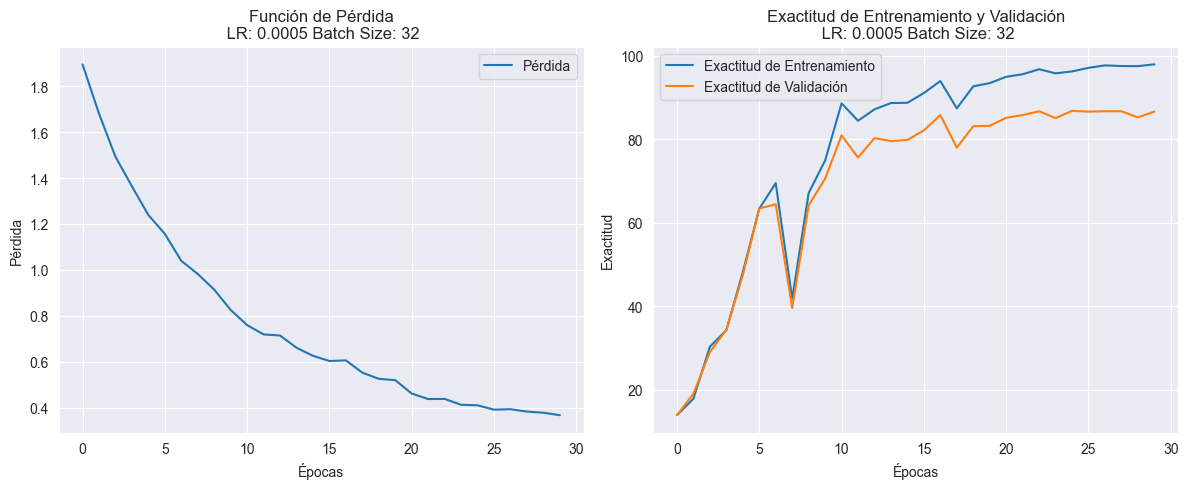


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 2.0010, exactitud entrenamiento: 20.98%, exactitud validación: 19.54%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.8233, exactitud entrenamiento: 21.93%, exactitud validación: 22.02%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6676, exactitud entrenamiento: 37.09%, exactitud validación: 36.88%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.5124, exactitud entrenamiento: 40.60%, exactitud validación: 38.53%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.3882, exactitud entrenamiento: 50.28%, exactitud validación: 49.45%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.2530, exactitud entrenamiento: 52.00%, exactitud validación: 48.17%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.1482, exactitud entrenamiento: 51.97%, exactitud validación: 47.89%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.0842, exactitud entrenamiento: 65.50%, exactitud validación: 62

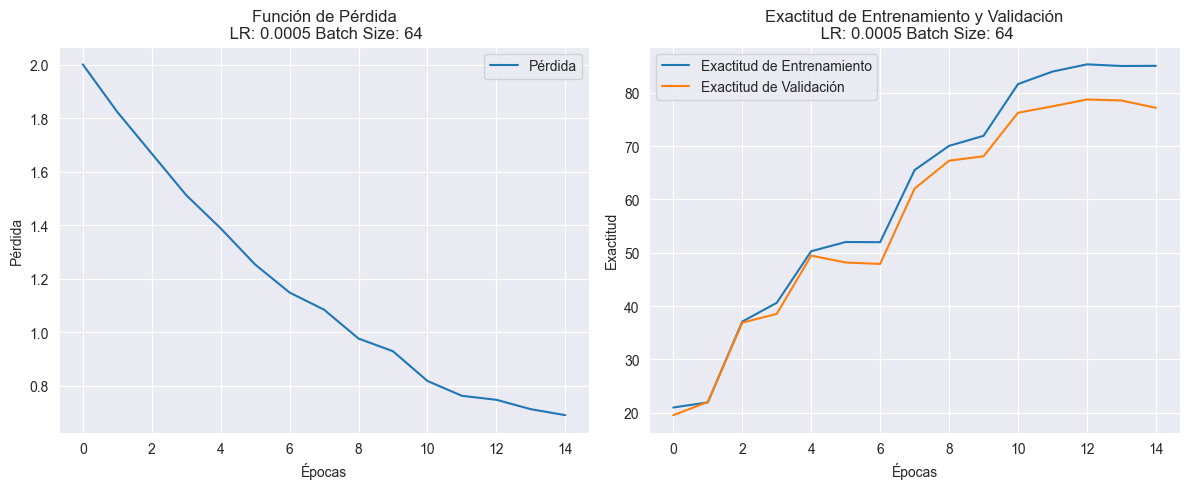


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.9452, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7299, exactitud entrenamiento: 14.82%, exactitud validación: 14.86%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.5999, exactitud entrenamiento: 14.63%, exactitud validación: 14.40%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.4724, exactitud entrenamiento: 24.15%, exactitud validación: 23.94%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.3479, exactitud entrenamiento: 38.66%, exactitud validación: 38.81%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.2361, exactitud entrenamiento: 39.93%, exactitud validación: 39.45%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.1068, exactitud entrenamiento: 59.33%, exactitud validación: 57.71%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.0242, exactitud entrenamiento: 58.41%, exactitud validación: 56

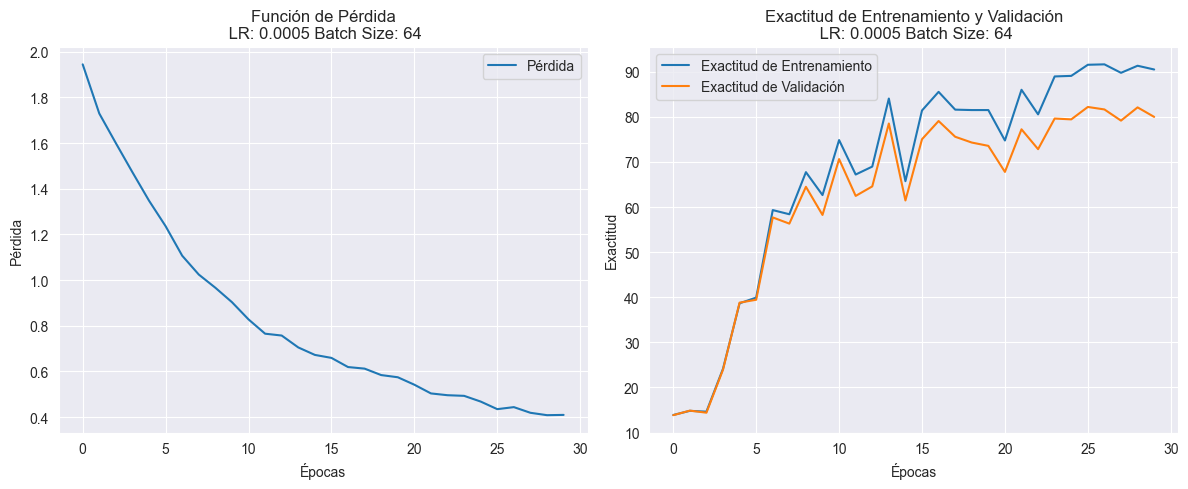


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 2.0468, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9284, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8747, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8130, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7718, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7147, exactitud entrenamiento: 14.29%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.6462, exactitud entrenamiento: 14.45%, exactitud validación: 14.22%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6199, exactitud entrenamiento: 15.93%, exactitud validación: 15

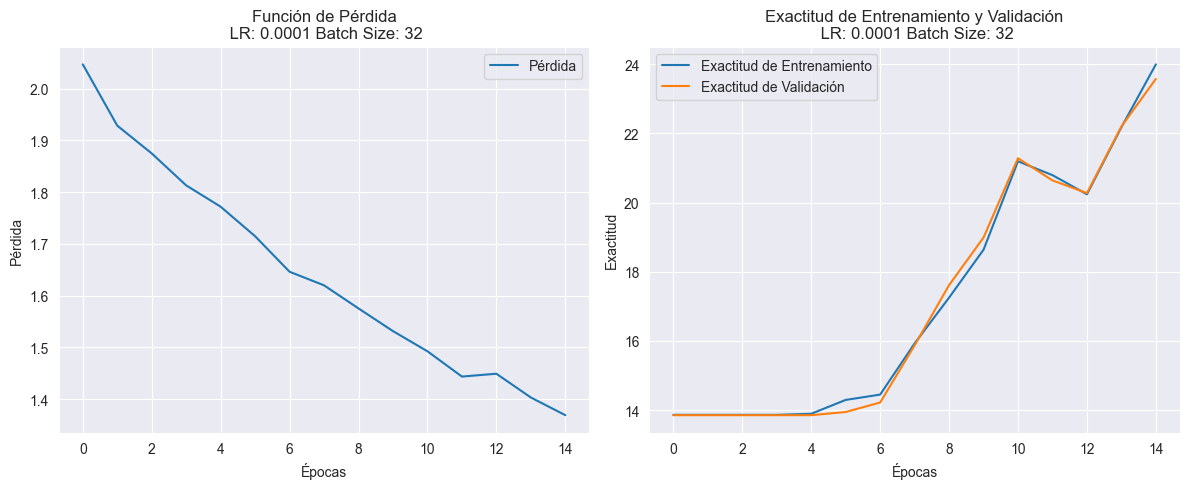


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 2.0211, exactitud entrenamiento: 13.99%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9142, exactitud entrenamiento: 13.96%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8407, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.7730, exactitud entrenamiento: 13.92%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7259, exactitud entrenamiento: 14.29%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.6616, exactitud entrenamiento: 16.76%, exactitud validación: 16.51%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.6191, exactitud entrenamiento: 18.42%, exactitud validación: 17.98%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.5781, exactitud entrenamiento: 22.34%, exactitud validación: 22

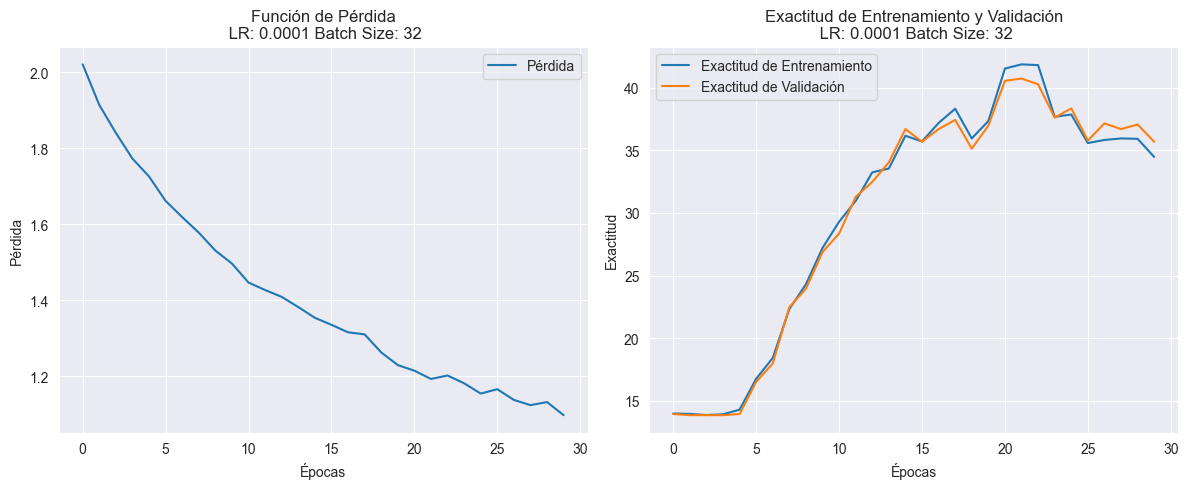


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 2.0383, exactitud entrenamiento: 14.02%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9562, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8942, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8333, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7856, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7383, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.6867, exactitud entrenamiento: 13.92%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6421, exactitud entrenamiento: 13.96%, exactitud validación: 13

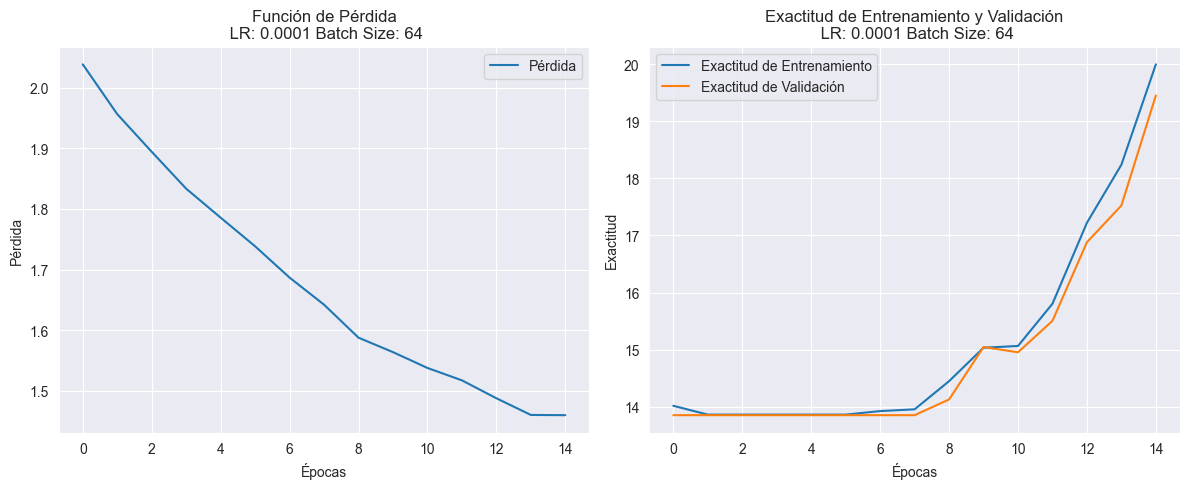


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 2.0572, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9903, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9321, exactitud entrenamiento: 13.92%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8853, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8421, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7864, exactitud entrenamiento: 13.89%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7589, exactitud entrenamiento: 13.89%, exactitud validación: 14.13%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7138, exactitud entrenamiento: 13.99%, exactitud validación: 14

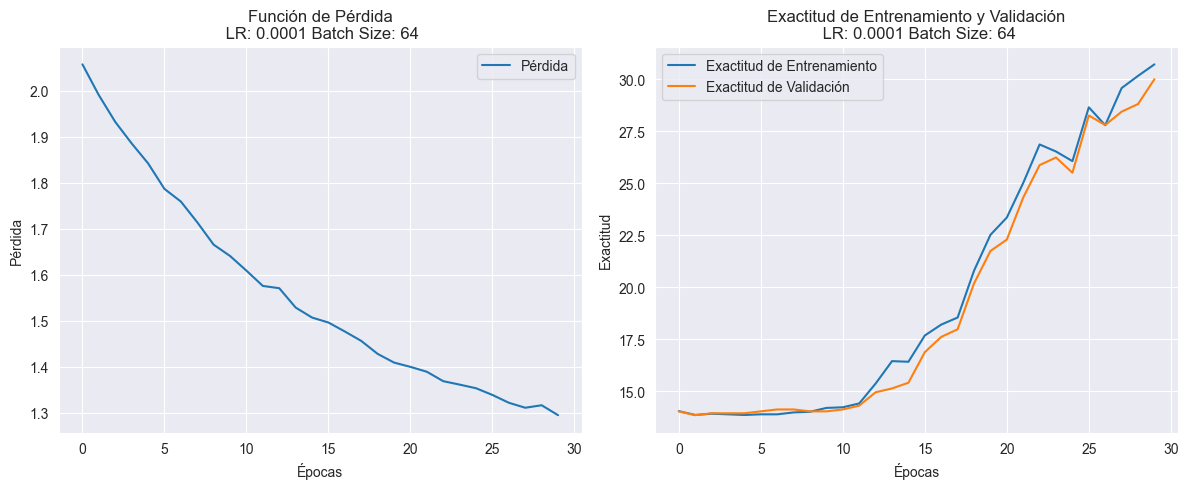


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0349, exactitud entrenamiento: 17.25%, exactitud validación: 17.06%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.9960, exactitud entrenamiento: 18.55%, exactitud validación: 18.17%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9810, exactitud entrenamiento: 15.71%, exactitud validación: 15.32%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9233, exactitud entrenamiento: 18.61%, exactitud validación: 17.43%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.8895, exactitud entrenamiento: 19.07%, exactitud validación: 17.71%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8591, exactitud entrenamiento: 19.07%, exactitud validación: 17.80%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8174, exactitud entrenamiento: 14.94%, exactitud validación: 14.31%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.7733, exactitud entrenamiento: 16.42%, exactitud validación: 15.

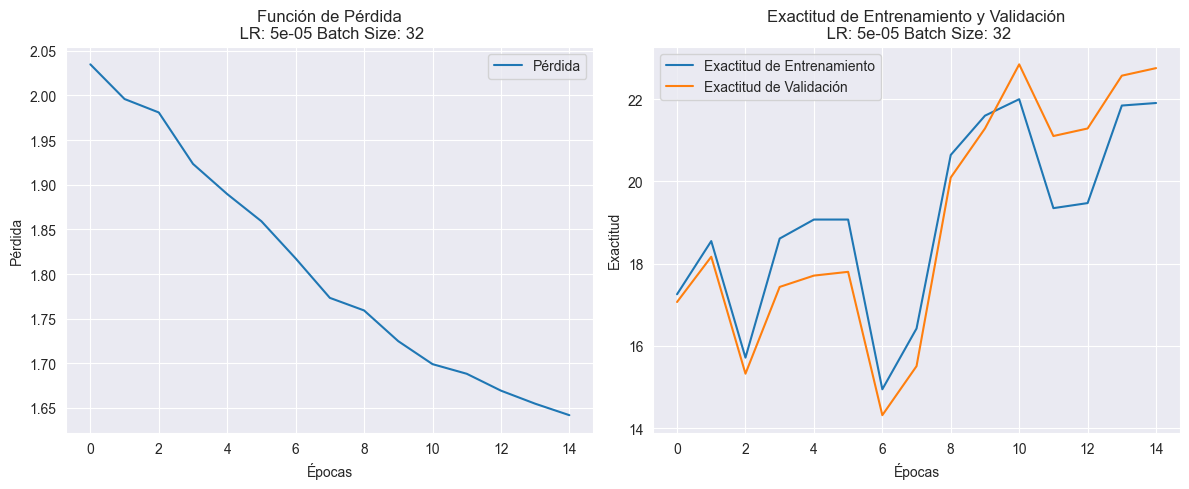


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0657, exactitud entrenamiento: 14.66%, exactitud validación: 14.59%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0152, exactitud entrenamiento: 14.33%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9652, exactitud entrenamiento: 14.63%, exactitud validación: 14.22%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9194, exactitud entrenamiento: 14.17%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9005, exactitud entrenamiento: 14.54%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8757, exactitud entrenamiento: 14.76%, exactitud validación: 14.40%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8575, exactitud entrenamiento: 15.06%, exactitud validación: 14.50%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8123, exactitud entrenamiento: 15.00%, exactitud validación: 14.

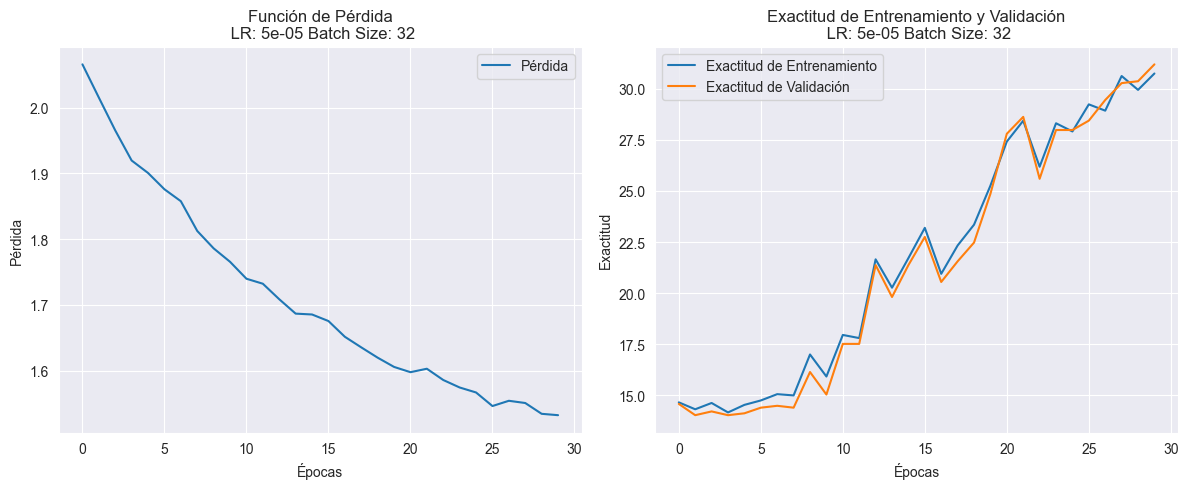


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0635, exactitud entrenamiento: 19.78%, exactitud validación: 21.19%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0046, exactitud entrenamiento: 16.08%, exactitud validación: 16.51%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9666, exactitud entrenamiento: 14.36%, exactitud validación: 14.68%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9345, exactitud entrenamiento: 14.39%, exactitud validación: 14.50%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9125, exactitud entrenamiento: 14.88%, exactitud validación: 15.05%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8749, exactitud entrenamiento: 15.16%, exactitud validación: 15.05%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8667, exactitud entrenamiento: 15.56%, exactitud validación: 15.23%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8345, exactitud entrenamiento: 15.74%, exactitud validación: 15.

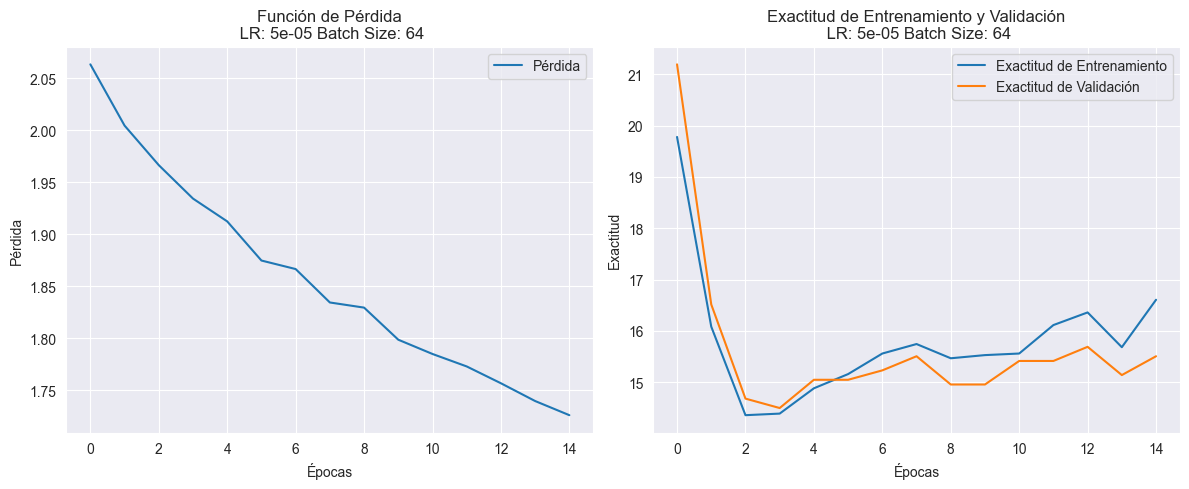


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0594, exactitud entrenamiento: 13.86%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0372, exactitud entrenamiento: 13.80%, exactitud validación: 13.67%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9883, exactitud entrenamiento: 16.20%, exactitud validación: 16.24%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9464, exactitud entrenamiento: 18.98%, exactitud validación: 18.44%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9320, exactitud entrenamiento: 16.14%, exactitud validación: 15.14%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9022, exactitud entrenamiento: 14.42%, exactitud validación: 14.40%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8780, exactitud entrenamiento: 14.45%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8689, exactitud entrenamiento: 14.42%, exactitud validación: 14.

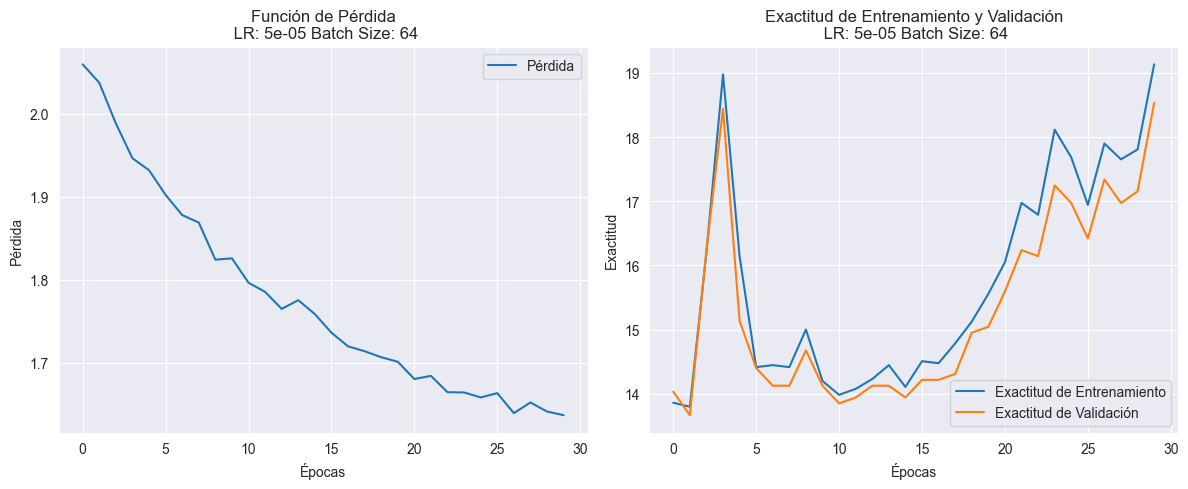


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0597, exactitud entrenamiento: 13.49%, exactitud validación: 13.12%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0320, exactitud entrenamiento: 14.91%, exactitud validación: 14.95%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0474, exactitud entrenamiento: 14.20%, exactitud validación: 14.13%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0123, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.9899, exactitud entrenamiento: 14.14%, exactitud validación: 14.13%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.9943, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9915, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9789, exactitud entrenamiento: 13.96%, exactitud validación: 13.

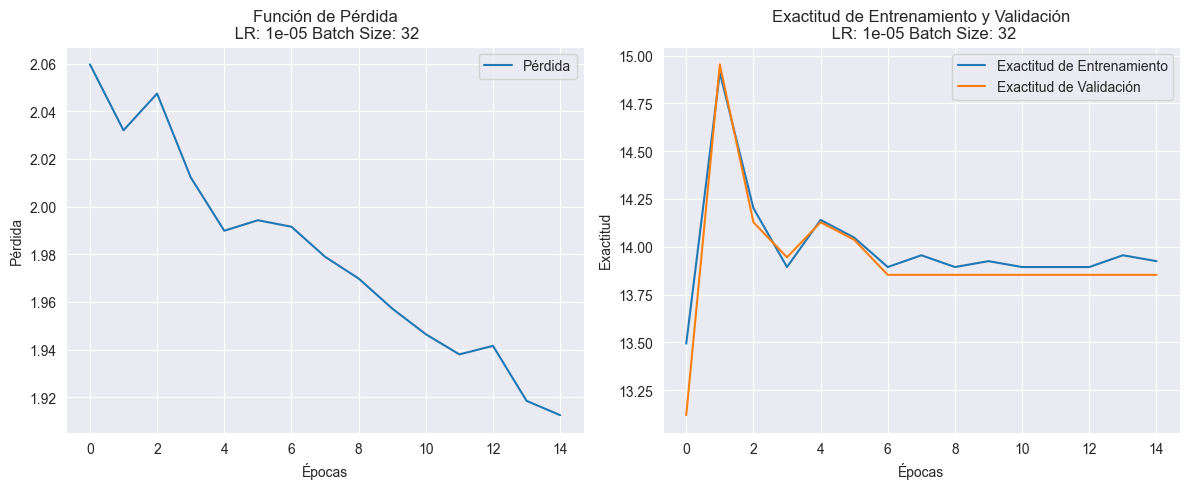


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0488, exactitud entrenamiento: 13.80%, exactitud validación: 13.67%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0451, exactitud entrenamiento: 16.02%, exactitud validación: 15.14%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0257, exactitud entrenamiento: 19.69%, exactitud validación: 18.35%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0203, exactitud entrenamiento: 15.10%, exactitud validación: 15.69%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0185, exactitud entrenamiento: 14.23%, exactitud validación: 14.50%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.9930, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9764, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9676, exactitud entrenamiento: 13.86%, exactitud validación: 13.

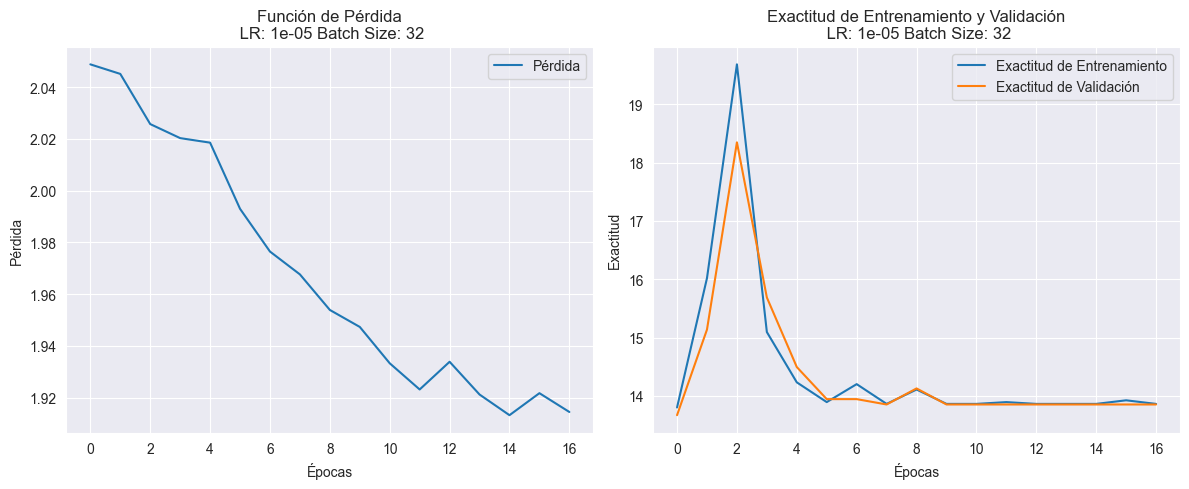


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0744, exactitud entrenamiento: 14.17%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0763, exactitud entrenamiento: 14.88%, exactitud validación: 14.86%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0658, exactitud entrenamiento: 15.03%, exactitud validación: 14.13%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0748, exactitud entrenamiento: 14.45%, exactitud validación: 15.14%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0520, exactitud entrenamiento: 16.33%, exactitud validación: 15.78%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0548, exactitud entrenamiento: 17.59%, exactitud validación: 16.15%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0354, exactitud entrenamiento: 16.45%, exactitud validación: 16.33%
Learning rate actual: 0.000010
    Época 8, pérdida: 2.0169, exactitud entrenamiento: 14.94%, exactitud validación: 14.

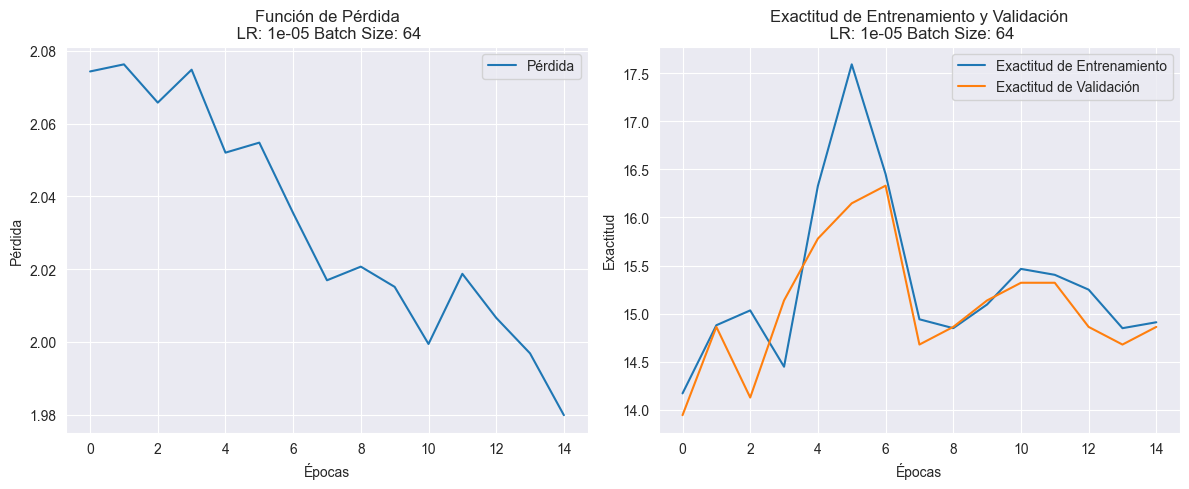


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0759, exactitud entrenamiento: 18.88%, exactitud validación: 19.08%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0671, exactitud entrenamiento: 20.64%, exactitud validación: 21.28%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0405, exactitud entrenamiento: 18.82%, exactitud validación: 19.45%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0407, exactitud entrenamiento: 19.50%, exactitud validación: 18.90%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0375, exactitud entrenamiento: 16.27%, exactitud validación: 16.61%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0303, exactitud entrenamiento: 15.59%, exactitud validación: 15.69%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0096, exactitud entrenamiento: 14.66%, exactitud validación: 15.23%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9770, exactitud entrenamiento: 14.23%, exactitud validación: 14.

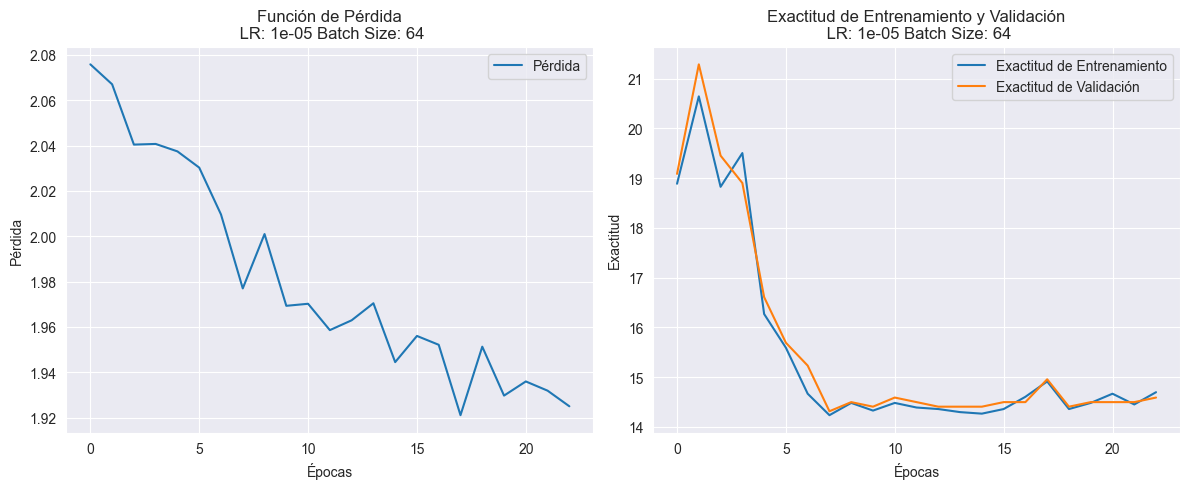

In [8]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)
        
        scheduler.step()
        
        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')
        
        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=88.62%
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=87.98%
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=87.25%
    LR=0.0005, Batch=32, Epochs=30, Exactitud validación=86.61%
    LR=0.005, Batch=32, Epochs=15, Exactitud validación=83.85%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.005, Batch=32, Epochs=30    : 84.51%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8247    0.8523    0.8383       149
           1     0.9580    0.9013    0.9288       152
           2     0.7763    0.7919    0.7841       149
           3     0.8218    0.8266    0.8242       173
           4     0.8710    0.9000    0.8852       150
           5     0.7467    0.7517    0.7492       149
           6     0.9267    0.8910    0.9085       156

    accuracy                         0.8451      1078
   macro avg     0.8465    

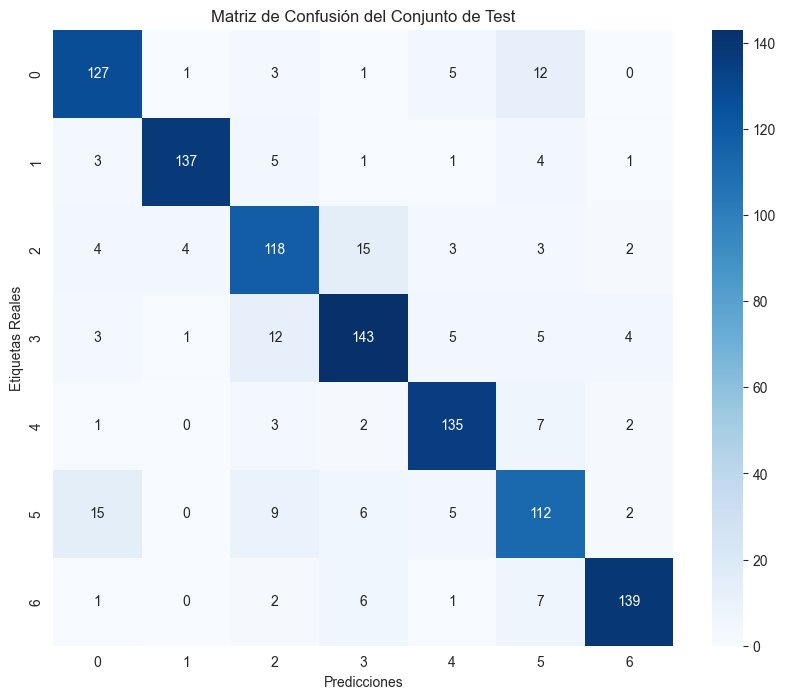

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [10]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)